In [84]:
import imp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import sys
import tensorflow as tf
from tensorflow import keras

%matplotlib inline

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer

import os
tf.random.set_seed(42)


sys.path.insert(0, '../../src')
from utils import df_to_xarray,read_xarray,inverse_scale_image, get_point_prediction

sys.path.insert(0, '../../src/preprocess')
from data_preprocess import preprocess_image_reduced,preprocess_images_nfp,preprocess_images

In [85]:
tf.keras.backend.clear_session()

In [86]:
import tensorflow.keras.backend as kb
import tensorflow as tf
from tensorflow.keras import backend as K

def custom_rmse(y_true, y_pred):
    """
    custom_rmse(y_true, y_pred)
    calculates root square mean value with focusing only on the ocean
    """
    y_pred = y_pred[(y_true != 0) & (y_true != 0.0)]
    y_true = y_true[(y_true != 0) & (y_true != 0.0)]
    
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)

    return K.sqrt(K.mean(tf.math.squared_difference(y_pred, y_true),axis= -1))

In [87]:
dir_name="../../data/data1"
val_dir_name="../../data/data2"

data,pco2 = preprocess_images(dir_name)
data_socat, pco2_socat = preprocess_images(dir_name, socat = True)

val_data,val_pco2 = preprocess_images(val_dir_name,"035")
val_data_socat,val_pco2_socat = preprocess_images(val_dir_name,"035",socat=True)

INPUT_SHAPE=data_socat[0].shape
OUTPUT_SHAPE=pco2_socat[0].shape

chl,mld,sss,sst,u10,fg_co2,xco2,icefrac,patm,pco2t = read_xarray(dir_name)
chl,mld,sss,sst,u10,fg_co2,xco2,icefrac,patm,pco2t2 = read_xarray(val_dir_name,num="035")

In [88]:
def eliminate_zero_pco2(pco2,socat=True):
    if socat:
        tmp=np.array(pco2.pCO2_socat.data)
    else:
        tmp=np.array(pco2.pCO2.data)
        
    ind=[]
    
    for i in range(421):
        ind.append(np.nanmax(tmp[i]) != 0)
    
    return ind,tmp[ind]

In [89]:
id1,pco2_1 = eliminate_zero_pco2(pco2t)
pco2_1 = preprocess_image_reduced(pco2_1)
data_socat = data_socat[id1]


id2,pco2_2 = eliminate_zero_pco2(pco2t2)
pco2_2 = preprocess_image_reduced(pco2_2)
data_socat2 = val_data_socat[id2]

pco2_socat=np.vstack([pco2_1,pco2_2])
data_socat=np.vstack([data_socat,data_socat2])
data=np.vstack([data[id1],val_data[id2]])

print(pco2_socat.shape,data.shape)


(788, 180, 360) (788, 180, 360, 5)


In [90]:
from tensorflow.keras.layers import Dense, Reshape, Conv2D, MaxPool2D , Flatten, Input

base_model = tf.keras.models.load_model('../../models/base_model/base_model_new.h5', custom_objects={'custom_rmse':custom_rmse})

for layer in base_model.layers:
    layer.trainable = True

base_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 360, 64)      8064      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 180, 360, 64)      102464    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 120, 64)       0         
_________________________________________________________________
dropout (Dropout)            (None, 60, 120, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 120, 128)      204928    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 120, 128)      409728    
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 180, 360, 128)     0

In [91]:
base_model.compile(
    loss=custom_rmse, optimizer=keras.optimizers.Adam(learning_rate=1e-4),
)

model_path="../../models/transfer_CNN.h5"

early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=4, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint]

epochs = 150
batch_size = 32

history = base_model.fit(
    data_socat,
    pco2_socat,
    batch_size=batch_size,
    epochs=epochs,
    workers=-1,
    validation_data=(data_socat, pco2_socat),
    callbacks=callbacks,
)

Epoch 1/150
25/25 [==============================] - 13s 490ms/step - loss: 26.4517 - val_loss: 16.1414
Epoch 2/150
25/25 [==============================] - 11s 439ms/step - loss: 16.7832 - val_loss: 15.0902
Epoch 3/150
25/25 [==============================] - 11s 438ms/step - loss: 15.6825 - val_loss: 14.0208
Epoch 4/150
25/25 [==============================] - 11s 439ms/step - loss: 14.5871 - val_loss: 13.0316
Epoch 5/150
25/25 [==============================] - 11s 439ms/step - loss: 13.7280 - val_loss: 12.1545
Epoch 6/150
25/25 [==============================] - 11s 439ms/step - loss: 12.9227 - val_loss: 11.3840
Epoch 7/150
25/25 [==============================] - 11s 439ms/step - loss: 12.0493 - val_loss: 10.7076
Epoch 8/150
25/25 [==============================] - 11s 439ms/step - loss: 11.7303 - val_loss: 10.1071
Epoch 9/150
25/25 [==============================] - 11s 439ms/step - loss: 11.1952 - val_loss: 9.5576
Epoch 10/150
25/25 [==============================] - 11s 439ms/s

In [96]:
best_model = tf.keras.models.load_model('../../models/transfer_CNN.h5', custom_objects={'custom_rmse':custom_rmse})

data_socat_test, pco2_socat = preprocess_images(dir_name, socat = True)

predicted_frames=best_model.predict(data_socat_test,verbose=1)
predicted_frames[pco2_socat==0]=0.0

14/14 [==============================] - 2s 111ms/step


In [97]:
def inverse_scale_image_socat(arr, df):
    """
    inverse_scale_image(arr, df):
    - inverses the pco2 scaling
    """    
    old_min = 0
    old_max = np.nanmax(df)
    y_pred = arr*(old_max-old_min)/255
    
    tmp=np.nan_to_num(df)
    y_true = tmp
    y_pred[y_true==0] = 0
    return y_true,y_pred

In [101]:
y_true,y_pred = inverse_scale_image_socat(predicted_frames,pco2t.pCO2_socat.data)  

print("Full RMSE score:")
custom_rmse(y_pred,y_true)

Full RMSE score:


7.9507831594334615

In [99]:
np.nanmax(y_true-pco2t.pCO2.data)

0.0

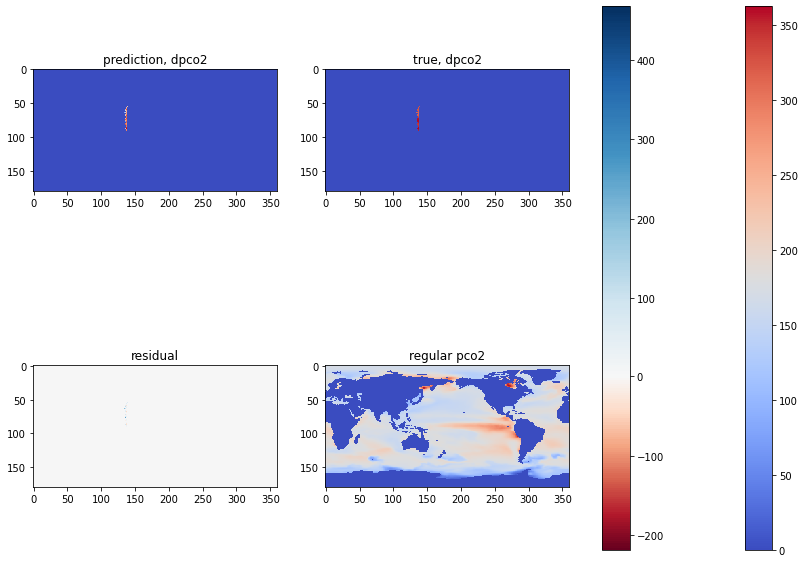

In [102]:
import matplotlib.colors as mcolors

figure, axis = plt.subplots(2, 2,figsize=(15, 10))

d = y_true - y_pred

norm = mcolors.TwoSlopeNorm(vmin=d.min(), vmax = d.max(), vcenter=0)

img=axis[0][0].imshow(np.flipud(y_pred[0]),cmap="coolwarm", interpolation="nearest")
axis[0][0].set_title("prediction, dpco2")
plt.colorbar(img,ax=axis)

img1=axis[0][1].imshow(np.flipud(y_true[0]),cmap="coolwarm", interpolation="nearest")
axis[0][1].set_title("true, dpco2")

diff=np.flipud(np.squeeze(y_true[0]-y_pred[0]))
img2=axis[1][0].imshow(diff,cmap="RdBu", interpolation="nearest",norm=norm)
axis[1][0].set_title("residual")
plt.colorbar(img2,ax=axis)


img2=axis[1][1].imshow(np.flipud(pco2[0]),cmap="coolwarm", interpolation="nearest")
axis[1][1].set_title("regular pco2")

#plt.savefig('../../assets/transfer_nfp.png')

plt.show()

In [103]:
#full data set
data_test,pco2_test = preprocess_images(dir_name)
predicted_frames=best_model.predict(data_test,verbose=1)
predicted_frames[pco2==0]=0.0

14/14 [==============================] - 1s 111ms/step


In [104]:
def inverse_scale_image(arr, df):
    """
    inverse_scale_image(arr, df):
    - inverses the pco2 scaling
    """
    
    old_min = np.nanmin(df)
    old_max = np.nanmax(df)

    y_pred = arr*(old_max-old_min)/255+old_min
    
    y_true=np.nan_to_num(df)
    y_pred[y_true==0]=0
    return y_true,y_pred

In [105]:
y_true,y_pred = inverse_scale_image(predicted_frames,pco2t.pCO2.data)  

print("Full RMSE score:")
np.sqrt(custom_rmse(y_pred,y_true))

Full RMSE score:


14.292949526021458

(array([2.8000000e+02, 1.5380000e+03, 9.5270000e+03, 1.1375800e+05,
        9.6621800e+05, 2.0079190e+06, 2.3195950e+06, 2.5858330e+06,
        2.5865310e+06, 1.9353590e+06, 1.3345180e+06, 9.5182800e+05,
        6.8816900e+05, 4.9207900e+05, 3.7868500e+05, 2.9602300e+05,
        2.0569400e+05, 1.0131647e+07, 9.3618000e+04, 5.7297000e+04,
        3.3306000e+04, 1.9941000e+04, 1.3102000e+04, 9.2820000e+03,
        7.2730000e+03, 5.6620000e+03, 5.1750000e+03, 5.5980000e+03,
        6.0960000e+03, 6.2950000e+03, 4.9360000e+03, 3.3850000e+03,
        1.9580000e+03, 1.1070000e+03, 6.5100000e+02, 3.8800000e+02,
        2.0700000e+02, 1.3100000e+02, 8.3000000e+01, 5.2000000e+01,
        2.5000000e+01, 1.5000000e+01, 1.0000000e+01, 2.0000000e+00,
        1.0000000e+00, 0.0000000e+00, 2.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 1.0000000e+00]),
 array([-378.93842533, -357.78591736, -336.63340939, -315.48090142,
        -294.32839345, -273.17588548, -252.02337751, -230.87086954,
        

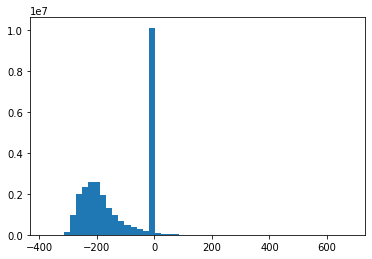

In [109]:
plt.hist(np.array(y_true-y_pred).flatten(),bins=50)

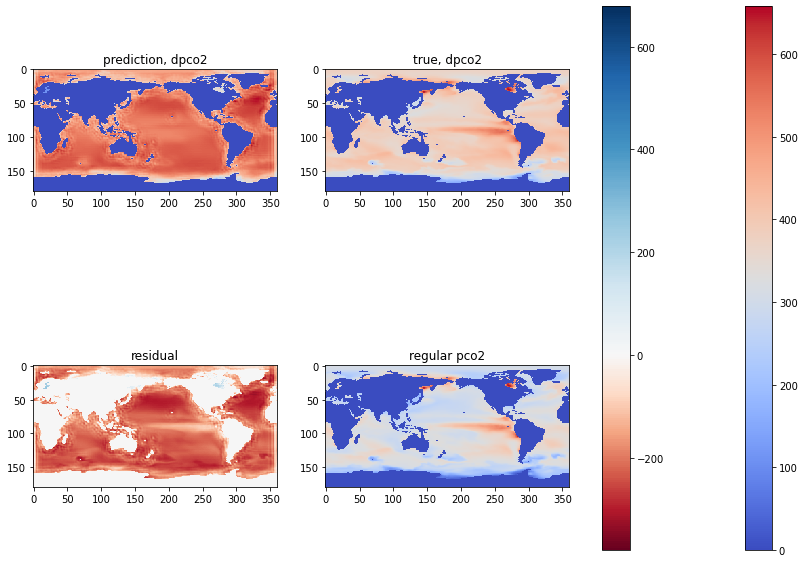

In [107]:

figure, axis = plt.subplots(2, 2,figsize=(15, 10))

d = y_true - y_pred

norm = mcolors.TwoSlopeNorm(vmin=d.min(), vmax = d.max(), vcenter=0)

img=axis[0][0].imshow(np.flipud(y_pred[0]),cmap="coolwarm", interpolation="nearest")
axis[0][0].set_title("prediction, dpco2")
plt.colorbar(img,ax=axis)

img1=axis[0][1].imshow(np.flipud(y_true[0]),cmap="coolwarm", interpolation="nearest")
axis[0][1].set_title("true, dpco2")

diff=np.flipud(np.squeeze(y_true[0]-y_pred[0]))
img2=axis[1][0].imshow(diff,cmap="RdBu", interpolation="nearest",norm=norm)
axis[1][0].set_title("residual")
plt.colorbar(img2,ax=axis)


img2=axis[1][1].imshow(np.flipud(pco2[0]),cmap="coolwarm", interpolation="nearest")
axis[1][1].set_title("regular pco2")

#plt.savefig('../../assets/transfer_nfp.png')

plt.show()